In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches
from timeit import timeit

## Calculate random Euler angles

In [2]:
# return n "random" Euler angles in radians
def random(n):
    return 2*np.pi*np.random.rand(n,3)

In [3]:
ea = random(50)
print(ea[:10,])

[[1.50897731 2.9878526  3.99053767]
 [5.84397627 2.63239684 3.11989723]
 [2.40403779 0.43984587 1.21215619]
 [4.38858119 2.45059197 3.18598295]
 [1.85985462 3.0431048  4.24286051]
 [5.15337226 0.36847762 4.94629256]
 [2.83415608 4.08161682 5.33623453]
 [3.39384432 2.86029053 0.33480992]
 [4.84492732 2.07882082 4.20459962]
 [4.32788145 3.55483275 2.28350059]]


## Convert Euler angles into rotation matrices

In [4]:
def trans2(a):
    s=list(range(len(a.shape)))
    return np.transpose(a,s[:-2]+s[-1:-3:-1])
# return rotation matrices from Euler angles ea
def matrices(ea):
    def trans1(a):
        s=list(range(len(a.shape)))
        return np.transpose(a,s[2:]+s[:2])
    def rot_z(a):
        c,s=np.cos(a),np.sin(a)
        u=1.*(a==a); z=0.*u
        return trans1(np.array([[c,-s,z],[s,c,z],[z,z,u]]))
    def rot_x(a):
        c,s=np.cos(a),np.sin(a)
        u=1.*(a==a); z=0.*u
        return trans1(np.array([[u,z,z],[z,c,-s],[z,s,c]]))
    phi1,Phi,phi2=np.transpose(ea)
    r=rot_z(phi2)@rot_x(Phi)@rot_z(phi1)
    return trans2(r)

In [5]:
rot = matrices(ea)
print(rot[:10,])

[[[-0.7811364   0.60536357  0.15284262]
  [ 0.61368929  0.78949094  0.00946064]
  [-0.11494074  0.10118793 -0.98820526]]

 [[-0.9129297  -0.35155636 -0.20728603]
  [-0.40797982  0.7993046   0.44120813]
  [ 0.01057515  0.48736052 -0.87313681]]

 [[-0.82953904 -0.47945093  0.2863421 ]
  [ 0.39101986 -0.8647483  -0.31514101]
  [ 0.39870849 -0.14945632  0.9048173 ]]

 [[ 0.35028449 -0.71572161 -0.60418818]
  [-0.9362163  -0.28701932 -0.20277807]
  [-0.02828103  0.63668083 -0.77060866]]

 [[-0.7216666   0.68579471  0.09424932]
  [ 0.68666453  0.72643391 -0.02802857]
  [-0.08768775  0.04449038 -0.99515399]]

 [[-0.72172891 -0.61073976 -0.3257366 ]
  [ 0.59693903 -0.78741807  0.15374191]
  [-0.35038718 -0.08348491  0.93287678]]

 [[-0.70162678  0.66932504 -0.24438464]
  [ 0.27945789  0.57398087  0.76970725]
  [ 0.65545645  0.471752   -0.58976851]]

 [[-0.99337054 -0.09172978 -0.0692865 ]
  [-0.06995795  0.96064611 -0.26882137]
  [ 0.09121873 -0.26219209 -0.96069478]]

 [[ 0.35708655 -0.349937

## Plot pole figures

In [6]:
# plot p pole figure from rotation matrices rot
def plot(rot, p, *args, **kvargs):
    def circle1(size):
        plt.figure(figsize=(size,size))
        ax = plt.gca()
        # Make the circle patch and add to the figure
        circle = plt.Circle((0, 0), 1, color='#777', fill=None)
        ax.add_patch(circle)   
        # Make it a perfect circle by making it a perfect square box
        ax.set_aspect('equal', adjustable='box')
        # Set axis so it's visible 
        plt.xlim([-1.01,1.01])  
        plt.ylim([-1.01,1.01])
        ax.spines['left'].set_position('center')
        ax.spines['bottom'].set_position('center')
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.set_xticks([])
        ax.set_yticks([])
    def stereo_n(n,size=3,color='r'):
        n = (np.abs(n[:,2:])<1)*n
        xy = n[:,:2]/(1-n[:,2:])
        yx = -n[:,:2]/(1+n[:,2:])
        m = (xy*xy).sum(axis=1)
        xy = np.where(np.transpose([m,m])<=1,xy,yx)
        circle1(size)
        if isinstance(color, np.ndarray):
            cmap = plt.cm.rainbow
            norm = matplotlib.colors.Normalize(vmin=np.min(color), vmax=np.max(color))
            color = cmap(norm(color))
        plt.scatter(xy[:,1], -xy[:,0], color=color, marker='.')
        plt.show()
        plt.close()
    p = np.array(p)
    n = rot@(p/(p*p).sum()**0.5)
    stereo_n(n,*args,**kvargs)

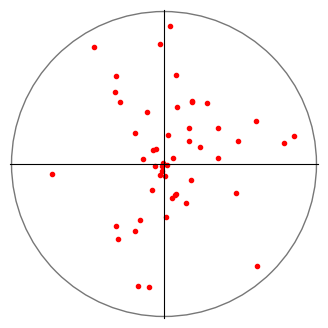

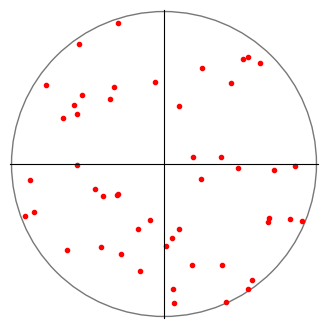

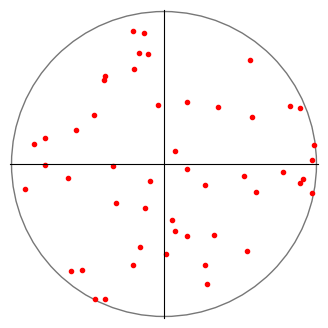

In [7]:
plot(rot, [0,0,1], size=4)
plot(rot, [1,0,0], size=4)
plot(rot, [1,1,0], size=4)

## Calculate misorientations

In [8]:
def norm(v):
    n=(v*v).sum(axis=-1)
    n=np.where(n==0,1,n)
    return np.transpose(np.transpose(v)/n**0.5)
def ang(r):
    return np.arccos(np.clip((np.trace(r,axis1=-2,axis2=-1)-1)/2.,-1,1))
def axis(r):
    s=list(range(len(r.shape)))
    r=np.transpose(r-trans2(r),s[-2:]+s[:-2])
    return norm(np.transpose([r[1,2],r[2,0],r[0,1]]))
def misorientations(csym,r):
    d=[]
    for ri,rj in itertools.combinations(r,2):
        d.append(ri@trans2(rj))
    p=[]
    for s,di in itertools.product(csym,d):
        p.append(s@di)
    p=np.array(p).reshape(len(csym),len(d),3,3)
    a=ang(p)
    m=a.argmin(axis=0)
    i=(m,range(len(m)))
    return a[i],axis(p[i])

In [9]:
def Rmiller(hkl,uvw):
    assert(0==np.dot(hkl,uvw)) # must be perpendicular
    n,d=norm(np.array(hkl)),norm(np.array(uvw))
    c=norm(np.cross(n,d))
    return np.array([d,c,n])

In [10]:
cubic=[
    # face 001 perpendicular to 001
    Rmiller([0,0,1],[1,0,0]),Rmiller([0,0,1],[0,1,0]),Rmiller([0,0,1],[-1,0,0]),Rmiller([0,0,1],[0,-1,0]),
    # face 010 perpendicular to 001
    Rmiller([0,1,0],[1,0,0]),Rmiller([0,1,0],[0,0,1]),Rmiller([0,1,0],[-1,0,0]),Rmiller([0,1,0],[0,0,-1]),
    # face 100 perpendicular to 001
    Rmiller([1,0,0],[0,0,1]),Rmiller([1,0,0],[0,1,0]),Rmiller([1,0,0],[0,0,-1]),Rmiller([1,0,0],[0,-1,0]),
    # face -001 perpendicular to 001
    Rmiller([0,0,-1],[1,0,0]),Rmiller([0,0,-1],[0,1,0]),Rmiller([0,0,-1],[-1,0,0]),Rmiller([0,0,-1],[0,-1,0]),
    # face -010 perpendicular to 001
    Rmiller([0,-1,0],[1,0,0]),Rmiller([0,-1,0],[0,0,1]),Rmiller([0,-1,0],[-1,0,0]),Rmiller([0,-1,0],[0,0,-1]),
    # face -100 perpendicular to 001
    Rmiller([-1,0,0],[0,0,1]),Rmiller([-1,0,0],[0,1,0]),Rmiller([-1,0,0],[0,0,-1]),Rmiller([-1,0,0],[0,-1,0])
]
a,ax = misorientations(cubic, rot)

In [11]:
d = (180*a[:10])/np.pi
print(d)

[35.86996333 30.8468079  44.29548541  6.80165308 29.67548588 44.77811384
 48.12051432 39.33572781 25.58110851 39.09308816]


# Using quaternions

## Quaternions from Euler angles

In [12]:
def quaternion1(angle, axis):
    ha,axis=angle/2,np.array(axis)
    c,s,u=np.cos(ha),np.sin(ha),axis/(axis**2).sum()**0.5
    if isinstance(angle,np.ndarray):
        return np.append(c[:,np.newaxis],s[:,np.newaxis]*u,axis=-1)
    return np.append(c,s*u)
def mul(p, q):
    p,q=np.transpose(p),np.transpose(q)
    r=p[0]*q[0]-p[1]*q[1]-p[2]*q[2]-p[3]*q[3]
    i=p[0]*q[1]+p[1]*q[0]+p[2]*q[3]-p[3]*q[2]
    j=p[0]*q[2]-p[1]*q[3]+p[2]*q[0]+p[3]*q[1]
    k=p[0]*q[3]+p[1]*q[2]-p[2]*q[1]+p[3]*q[0]
    return np.transpose(np.array([r,i,j,k]))
def quaternion(angle, axis=None):
    if axis is None:
        x,z=np.array([1,0,0]),np.array([0,0,1])
        phi1,Phi,phi2=np.transpose(-angle)
        return mul(quaternion1(phi2,z),mul(quaternion1(Phi,x),quaternion1(phi1,z)))
    return quaternion1(angle, axis)

In [13]:
q = quaternion(ea)
print(q[:10,])

[[-0.07097409 -0.32310134  0.94324342 -0.02932662]
 [-0.05752847 -0.20056328 -0.94675381  0.24519802]
 [-0.22941772 -0.18054913 -0.12244738 -0.94856532]
 [-0.27048868 -0.77587249 -0.53228396  0.2037929 ]
 [-0.04902376 -0.36981532  0.92780042 -0.00443571]
 [ 0.32547266 -0.18221717 -0.01893445  0.92763459]
 [ 0.2657939  -0.28025027  0.8463711  -0.36670063]
 [-0.04056106 -0.04085989 -0.98928149 -0.1341917 ]
 [-0.09451837 -0.81829674 -0.27132368  0.4978355 ]
 [ 0.20239701 -0.5104059  -0.83510362 -0.03351439]]


## Calculate misorientations

In [14]:
def conj(q):
    q=np.transpose(q)
    return np.transpose(np.append(q[:1,],-q[1:,],axis=0))
def qmis(csym,q,p=None):
    if p is None:
        qs,ps=[],[]
        for qi,pi in itertools.combinations(q,2):
            qs.append(qi)
            ps.append(pi)
        q,p=qs,ps
    d=mul(conj(np.array(p)),np.array(q))
    qs=np.array([mul(c,d) for c in csym])
    return qs[np.argmax(np.abs(qs[:,:,0]),axis=0),range(qs.shape[1]),:]
def angleaxis(q):
    r,i,j,k=np.transpose(q)
    u=np.array([i,j,k])
    m=(u**2).sum(axis=0)**0.5
    a=2*np.arccos(np.clip(r,-1,1))
    return np.minimum(a,(2*np.pi)-a),np.transpose(u/(m+(m==0)))
def qmisorientations(csym,q,p=None):
    return angleaxis(qmis(cq,q,p))

In [15]:
cq=[
    # identity
    np.array([1,0,0,0]),
    # 4-fold 001
    quaternion(np.pi/2,[1,0,0]),quaternion(np.pi/2,[0,1,0]),quaternion(np.pi/2,[0,0,1]),
    quaternion(np.pi,[1,0,0]),quaternion(np.pi,[0,1,0]),quaternion(np.pi,[0,0,1]),
    quaternion(-np.pi/2,[1,0,0]),quaternion(-np.pi/2,[0,1,0]),quaternion(-np.pi/2,[0,0,1]),
    # 3-fold 111
    quaternion(2*np.pi/3,[1,1,1]),quaternion(-2*np.pi/3,[1,1,1]),
    quaternion(2*np.pi/3,[-1,1,1]),quaternion(-2*np.pi/3,[-1,1,1]),
    quaternion(2*np.pi/3,[1,-1,1]),quaternion(-2*np.pi/3,[1,-1,1]),
    quaternion(2*np.pi/3,[1,1,-1]),quaternion(-2*np.pi/3,[1,1,-1]),
    # 2-fold 110
    quaternion(np.pi,[1,1,0]),quaternion(np.pi,[0,1,1]),quaternion(np.pi,[1,0,1]),
    quaternion(np.pi,[-1,1,0]),quaternion(np.pi,[0,-1,1]),quaternion(np.pi,[-1,0,1])
]
a,ax = qmisorientations(cq, q)
d1 = (180*a[:10])/np.pi
print(d1)
print(np.allclose(d,d1,rtol=1e-12))

[35.86996333 30.8468079  44.29548541  6.80165308 29.67548588 44.77811384
 48.12051432 39.33572781 25.58110851 39.09308816]
True


# Timings

In [16]:
def nmis(n):
    return int((n*(n-1))/2)

In [17]:
tr=timeit('misorientations(cubic,rot)',globals=globals(),number=10)/10
tq=timeit('qmisorientations(cq,q)',globals=globals(),number=10)/10
print(len(q), nmis(len(q)), tr, tq, tr/tq)

50 1225 0.05782115000000001 0.0027794099999999934 20.803389928078314


In [18]:
ea = random(500)
tr=timeit('misorientations(cubic,matrices(ea))',globals=globals(),number=1)
tq=timeit('qmisorientations(cq,quaternion(ea))',globals=globals(),number=1)
print(500, nmis(500), tr, tq, tr/tq)

500 124750 9.024844000000002 0.533626700000001 16.912279689153458


In [19]:
ea = random(1000)
tr=100 # tr=timeit('misorientations(cubic,matrices(ea))',globals=globals(),number=1)
tq=timeit('qmisorientations(cq,quaternion(ea))',globals=globals(),number=1)
print(1000, nmis(1000), tr, tq, tr/tq)

1000 499500 100 2.347880700000001 42.5916018646092


In [20]:
ea = random(5)
def misorientations_loop(csym,ea):
    def rot_z(a):
        c,s=np.cos(a),np.sin(a)
        return np.array([[c,-s,0],[s,c,0],[0,0,1]])
    def rot_x(a):
        c,s=np.cos(a),np.sin(a)
        return np.array([[1,0,0],[0,c,-s],[0,s,c]])
    def rot(ea):
        # ea are the Euler angles as a numpy array of shape (3)
        # return orientation matrix (numpy array of shape (3,3))
        phi1,Phi,phi2=ea
        r=rot_z(phi2)@rot_x(Phi)@rot_z(phi1)
        return np.transpose(r)
    def misorientation(csym,r,s):
        dr=r@np.transpose(s)
        a=2*np.pi
        for sym in csym:
            ri=sym@dr
            ai,axi=ang(ri),axis(ri)
            if ai<a: a,ax=ai,axi
        return a,ax
    r = []
    for i in range(len(ea)):
        m = matrices(ea[i])
        r.append(m)
    a, ax = [], []
    for i in range(len(r)):
        for j in range(i+1,len(r)):
            ai,axi = misorientation(csym,r[i],r[j])
            a.append(ai)
            ax.append(axi)
    return np.array(a),np.array(ax)

In [21]:
print(misorientations_loop(cubic,random(5)))

(array([0.95349536, 0.57377182, 0.66743305, 0.58567123, 0.90154689,
       0.64548727, 0.83527868, 0.69873254, 0.83589592, 1.01623501]), array([[-0.77737959, -0.20044984, -0.59623891],
       [-0.28400496,  0.10931066,  0.95257145],
       [-0.46998984, -0.56845335,  0.67525576],
       [-0.66309544, -0.24359911, -0.70778804],
       [-0.39828039, -0.83621823, -0.3769772 ],
       [ 0.95207785,  0.22446257, -0.20776025],
       [-0.50416942,  0.86349137,  0.01399416],
       [ 0.38139924, -0.58329546,  0.71714784],
       [-0.69743601,  0.0365984 ,  0.71571193],
       [-0.31421018,  0.68498386,  0.65731962]]))


In [22]:
def timemis(n):
    global ea
    ea = random(n)
    tr1=timeit('misorientations_loop(cubic,ea)',globals=globals(),number=1)
    tr2=timeit('misorientations(cubic,matrices(ea))',globals=globals(),number=1)
    tq=timeit('qmisorientations(cq,quaternion(ea))',globals=globals(),number=1)
    print(f'{n:4} {nmis(n):5} {tr1:7.3f} {tr2:7.3f} {tq:7.3f} {tr1/tq:6.2f} {tr2/tq:6.2f} {tr1/tr2:6.2f}')
timemis(10)
timemis(50)
timemis(100)
timemis(200)

  10    45   0.071   0.004   0.001  48.87   2.76  17.69
  50  1225   1.283   0.090   0.004 304.81  21.48  14.19
 100  4950   4.758   0.284   0.011 441.92  26.42  16.73
 200 19900  20.470   1.372   0.045 452.99  30.35  14.92


In [23]:
n=3000
ea = random(n)
tq=timeit('qmisorientations(cq,quaternion(ea))',globals=globals(),number=1)
print(n, nmis(n), tq)

3000 4498500 19.888045299999995


In [24]:
# n>>> => too much memory needed (eg: n=5000 requires 8.9GB)
# strategy: divide in smaller groups (preferably optimised for cache size)
# step 2: run in parallel
# step 3: run in the GPU